In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler


In [329]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']


### Functions


In [327]:
def normalize_column(df, column):
    return RobustScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

In [328]:
def replace_outliers(data):
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:  # tylko dla kolumn numerycznych
            Q1 = data.groupby('Class')[column].quantile(0.25)
            Q3 = data.groupby('Class')[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            mean = data.groupby('Class')[column].mean()
            for class_name in data['Class'].unique():
                data.loc[(data['Class'] == class_name) & (data[column] < lower_bound[class_name]), column] = mean[class_name]
                data.loc[(data['Class'] == class_name) & (data[column] > upper_bound[class_name]), column] = mean[class_name]
    return data

In [330]:
def prepare_data(df):
    for col in df.columns:
        if col != "Class":
            df[col] = normalize_column(df, col)
    replace_outliers(df)
    return df

In [331]:
def select_columns(df):
    columns = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 
               'AspectRation', 'Eccentricity', 'roundness', 'Extent',
               'Solidity','ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class', 'ShapeFactor5']
    df = df[columns]
    return df

In [332]:
def select_columns_mlp(df):
    columns = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 
               'AspectRation', 'Eccentricity', 'roundness', 'Extent',
               'Solidity','ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']
    df = df[columns]
    return df

In [333]:
data = select_columns(df.copy())
data = prepare_data(data)
data_test = select_columns(df_test.copy())
data_test = prepare_data(data_test)
X_train = data.drop(columns=["Class"])
y_train = data["Class"]
X_test = data_test.drop(columns=["Class"])
y_test = data_test["Class"]

In [252]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

In [302]:
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=20, random_state=311, max_features=None,
                             warm_start=True)
ada = AdaBoostClassifier(estimator=rfc, algorithm='SAMME', n_estimators=500, random_state=311, learning_rate=0.01)

ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))


Accuracy: 0.9513816019587268
Balanced Accuracy: 0.9588359654390255

              precision    recall  f1-score   support

    BARBUNYA       0.97      0.93      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.97      0.96       342
    DERMASON       0.93      0.94      0.94       745
       HOROZ       0.99      0.98      0.99       405
       SEKER       0.97      0.98      0.97       426
        SIRA       0.92      0.91      0.91       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



In [160]:
param_grid = {"n_estimators": [200, 500, 700], "learning_rate": [0.1],
              "algorithm": ['SAMME']}

grid_search = GridSearchCV(ada, param_grid=param_grid, cv=7, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

final_ada = grid_search.best_estimator_
final_ada

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [265]:
final_ada.fit(X_train, y_train)
y_pred = final_ada.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=final_ada.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_ada.classes_)
disp.plot()

NameError: name 'final_ada' is not defined

### SVC

In [334]:
from sklearn.svm import SVC

svc = SVC(C=30, kernel='rbf', random_state=311, tol=1e-1, probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9552291010842953
Balanced accuracy: 0.9633588045112129

              precision    recall  f1-score   support

    BARBUNYA       0.98      0.95      0.96       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.96      0.98      0.97       342
    DERMASON       0.93      0.95      0.94       745
       HOROZ       0.99      0.98      0.99       405
       SEKER       0.98      0.99      0.98       426
        SIRA       0.92      0.91      0.91       554

    accuracy                           0.96      2859
   macro avg       0.97      0.96      0.96      2859
weighted avg       0.96      0.96      0.96      2859



### Kroswalidacja SVC

In [182]:
param_grid = {"C": [i for i in range(1, 30)], "kernel": ['rbf']}
grid_search = GridSearchCV(svc, param_grid=param_grid, cv=7, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(C=30, random_state=311, tol=0.1),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                               27, 28, 29],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

Accuracy: 0.9538300104931794
Balanced accuracy: 0.9626093363714602

              precision    recall  f1-score   support

    BARBUNYA       0.97      0.95      0.96       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.96      0.98      0.97       342
    DERMASON       0.93      0.94      0.94       745
       HOROZ       1.00      0.97      0.98       405
       SEKER       0.98      0.98      0.98       426
        SIRA       0.91      0.91      0.91       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



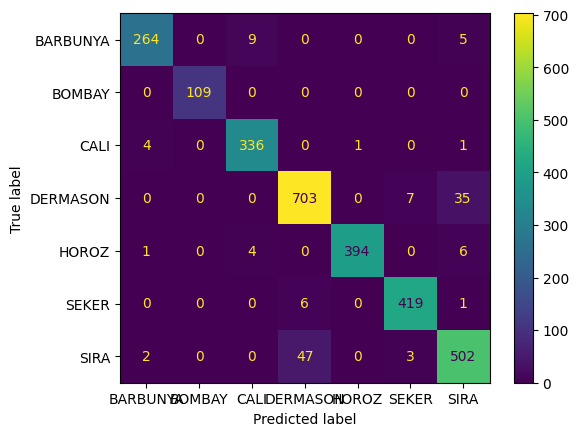

In [304]:
final_svc = grid_search.best_estimator_
final_svc.fit(X_train, y_train)
final_svc.predict(X_test)
y_pred = final_svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=final_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_svc.classes_)
disp.plot()

### MLP Classifier

Do tego lepiej pasują dane bez shapefactor5

In [312]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

data = select_columns_mlp(df.copy())
data = prepare_data(data)
data_test = select_columns_mlp(df_test.copy())
data_test = prepare_data(data_test)
X_train_mlp = data.drop(columns=["Class"])
y_train_mlp = data["Class"]
X_test_mlp = data_test.drop(columns=["Class"])
y_test_mlp = data_test["Class"]

Accuracy: 0.9524309199020636
Balanced accuracy: 0.9605478631707273

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.96      0.96       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.97      0.96      0.97       342
    DERMASON       0.93      0.95      0.94       745
       HOROZ       0.98      0.98      0.98       405
       SEKER       0.98      0.97      0.98       426
        SIRA       0.93      0.90      0.91       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


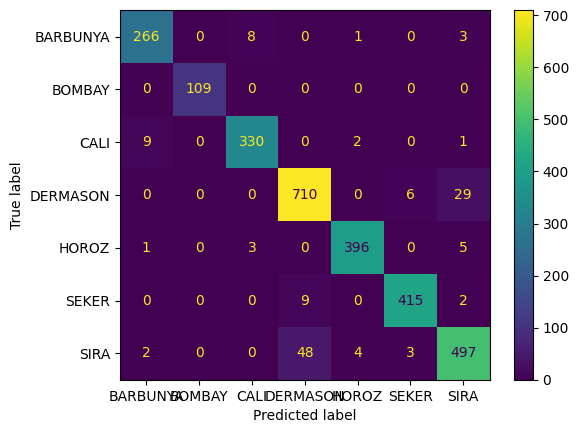

In [306]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=311, hidden_layer_sizes=(200,), activation='relu', solver='adam', alpha=0.0005, learning_rate='adaptive',
                    learning_rate_init=0.001, beta_1=0.1)
mlp.fit(X_train_mlp, y_train_mlp)
y_pred = mlp.predict(X_test_mlp)
print(f"Accuracy: {accuracy_score(y_test_mlp, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test_mlp, y_pred)}\n")
print(classification_report(y_test_mlp, y_pred))

cm = confusion_matrix(y_test_mlp, y_pred, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()

### GradientBoosting

In [307]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train2 = le.fit_transform(y_train)
y_test2 = le.transform(y_test)

xgb = XGBClassifier(learning_rate=0.07, random_state=311, objective='multi:softmax', max_depth=5, reg_alpha = 0.002, gamma=0.01, verbosity=0)
xgb.fit(X_train, y_train2)
y_pred = xgb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test2, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred)}\n")
print(classification_report(y_test2, y_pred))


Accuracy: 0.949982511367611
Balanced accuracy: 0.9572629184961878

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       278
           1       1.00      1.00      1.00       109
           2       0.94      0.97      0.96       342
           3       0.93      0.95      0.94       745
           4       0.99      0.97      0.98       405
           5       0.98      0.98      0.98       426
           6       0.91      0.91      0.91       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



In [308]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(objective='multiclass', random_state=311, learning_rate=0.15, reg_alpha=0.01, verbose=-1)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.95033228401539
Balanced accuracy: 0.9586953880725572

              precision    recall  f1-score   support

    BARBUNYA       0.97      0.93      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.98      0.96       342
    DERMASON       0.93      0.94      0.93       745
       HOROZ       0.99      0.97      0.98       405
       SEKER       0.97      0.98      0.98       426
        SIRA       0.91      0.91      0.91       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



### Nearest Neighbours


In [309]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', weights ='distance', n_neighbors=15, p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9447359216509269
Balanced accuracy: 0.9540904909142159

              precision    recall  f1-score   support

    BARBUNYA       0.99      0.92      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.94      0.99      0.97       342
    DERMASON       0.92      0.93      0.93       745
       HOROZ       0.99      0.96      0.98       405
       SEKER       0.97      0.97      0.97       426
        SIRA       0.88      0.91      0.90       554

    accuracy                           0.94      2859
   macro avg       0.96      0.95      0.96      2859
weighted avg       0.95      0.94      0.94      2859



# Voting Classifier

### Hard model

In [310]:
from sklearn.ensemble import VotingClassifier

estimators = [('ada', ada), ('mlp', mlp), ('xgb', xgb), ('lgb', lgb), ('knn', knn)]

model_hard = VotingClassifier(estimators=estimators, voting='hard')
model_hard.fit(X_train, y_train)
y_pred = model_hard.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))



c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9538300104931794
Balanced accuracy: 0.9608226347904942

              precision    recall  f1-score   support

    BARBUNYA       0.98      0.93      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.98      0.96       342
    DERMASON       0.93      0.95      0.94       745
       HOROZ       0.99      0.97      0.98       405
       SEKER       0.98      0.99      0.98       426
        SIRA       0.92      0.91      0.92       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



#### Z Wagami

In [276]:
weights = [0.05, 0.4, 0.1, 0.1, 0.35]
model_hard = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
model_hard.fit(X_train, y_train)
y_pred = model_hard.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9359916054564533
Balanced accuracy: 0.9477267196113454

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.95      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.97      0.96      0.97       342
    DERMASON       0.91      0.93      0.92       745
       HOROZ       0.97      0.95      0.96       405
       SEKER       0.96      0.97      0.96       426
        SIRA       0.89      0.87      0.88       554

    accuracy                           0.94      2859
   macro avg       0.95      0.95      0.95      2859
weighted avg       0.94      0.94      0.94      2859



### Soft model

In [277]:
model_soft = VotingClassifier(estimators=estimators, voting='soft')
model_soft.fit(X_train, y_train)
y_pred = model_soft.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9342427422175585
Balanced accuracy: 0.9450677007808709

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.95      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.96      0.96      0.96       342
    DERMASON       0.91      0.94      0.92       745
       HOROZ       0.97      0.94      0.95       405
       SEKER       0.96      0.96      0.96       426
        SIRA       0.88      0.87      0.88       554

    accuracy                           0.93      2859
   macro avg       0.95      0.95      0.95      2859
weighted avg       0.93      0.93      0.93      2859



#### Z wagami

In [278]:
model_soft = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
model_soft.fit(X_train, y_train)
y_pred = model_soft.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9359916054564533
Balanced accuracy: 0.9477267196113454

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.95      0.95       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.97      0.96      0.97       342
    DERMASON       0.91      0.93      0.92       745
       HOROZ       0.97      0.95      0.96       405
       SEKER       0.96      0.97      0.96       426
        SIRA       0.89      0.87      0.88       554

    accuracy                           0.94      2859
   macro avg       0.95      0.95      0.95      2859
weighted avg       0.94      0.94      0.94      2859



# Porównanie najlepszych modeli:

<Axes: xlabel='Class', ylabel='ShapeFactor5'>

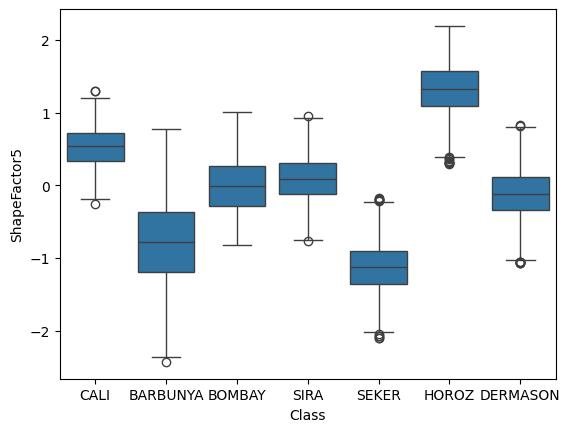

In [290]:
import seaborn as sns



sns.boxplot(data=data, x='Class', y='ShapeFactor5')

